In [4]:
from GraphSummarizers.Coarsener.HeteroCoarsener import HeteroCoarsener
from Datasets.NodeClassification.DBLP import DBLP
from Datasets.NodeClassification.AIFB import AIFB
from Datasets.NodeClassification.TestHetero import TestHeteroSmall, TestHeteroBig
import importlib
import torch
from test_data_converter import dgl_to_pyg_input

In [2]:

dataset = DBLP() 
original_graph = dataset.load_graph()


test = TestHeteroSmall().load_graph()

test = TestHeteroBig().load_graph()

coarsener = HeteroCoarsener(dataset, original_graph, 0.5)



In [3]:
H = coarsener._create_h_spatial_rgcn(original_graph)
candidates = coarsener._select_candidates(coarsener._find_lowest_cost_edges(coarsener._get_rgcn_edges(H)))
merged_graph, mapping_authors = coarsener._merge_nodes(original_graph, "author", candidates["author"])
#merged_graph, mapping_paper = coarsener._merge_nodes(merged_graph, "paper", candidates["paper"])
print(merged_graph)
print(original_graph)
#coarsener._costs_of_merges(candidates)

#coarsener._merge()

start create H


/home/robin/uu/thesis/convolution-matching/GraphSummarizers/Coarsener/HeteroCoarsener.py:125: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  degree = torch.tensor(self.node_degrees[etype]["out"]).to(device)
/home/robin/uu/thesis/convolution-matching/GraphSummarizers/Coarsener/HeteroCoarsener.py:128: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  degree = torch.tensor(self.node_degrees[etype]["in"]).to(device)


created H 12.665285348892212
start init costs
stop init costs 7.864163637161255
start lowest cost edges
stop lowest cost edges 0.6338255405426025
start select candidates
stop select canidates 0.011938095092773438
Graph(num_nodes={'author': 2580, 'conference': 20, 'paper': 14328, 'term': 7723},
      num_edges={('author', 'authortopaper', 'paper'): 19630, ('conference', 'conferencetopaper', 'paper'): 14328, ('paper', 'papertoauthor', 'author'): 4945, ('paper', 'papertoconference', 'conference'): 14328, ('paper', 'papertoterm', 'term'): 85810, ('term', 'termtopaper', 'paper'): 85810},
      metagraph=[('author', 'paper', 'authortopaper'), ('paper', 'author', 'papertoauthor'), ('paper', 'conference', 'papertoconference'), ('paper', 'term', 'papertoterm'), ('conference', 'paper', 'conferencetopaper'), ('term', 'paper', 'termtopaper')])
Graph(num_nodes={'author': 4057, 'conference': 20, 'paper': 14328, 'term': 7723},
      num_edges={('author', 'authortopaper', 'paper'): 19645, ('conference

In [7]:
original_data, o_x_dict, o_edge_index_dict, o_node_types, o_edge_types = dgl_to_pyg_input(original_graph)
coarsened_data, c_x_dict, c_edge_index_dict, c_node_types, c_edge_types = dgl_to_pyg_input(merged_graph)

In [8]:
import torch
import numpy as np
from torch_geometric.data import HeteroData

# Assuming you already have your hetero_data object
# hetero_data = HeteroData(...)

def create_train_val_test_masks(hetero_data, train_ratio=0.1, val_ratio=0.1, test_ratio=0.8, random_state=42, target_node_type='author'):
    """
    Create training, validation, and testing masks for author nodes.
    
    Args:
        hetero_data: HeteroData object
        train_ratio: Ratio of training data
        val_ratio: Ratio of validation data
        test_ratio: Ratio of testing data
        random_state: Random seed for reproducibility
    
    Returns:
        HeteroData object with train_mask, val_mask, and test_mask added to author nodes
    """
    # Ensure ratios sum to 1
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-6, "Ratios must sum to 1"
    
    # Get number of author nodes
    num_authors = hetero_data[target_node_type]["feat"].size(0)
    
    # Create random permutation of node indices
    np.random.seed(random_state)
    indices = np.random.permutation(num_authors)
    
    # Calculate split sizes
    train_size = int(num_authors * train_ratio)
    val_size = int(num_authors * val_ratio)
    
    # Split indices
    train_indices = indices[:train_size]
    val_indices = indices[train_size:train_size + val_size]
    test_indices = indices[train_size + val_size:]
    
    # Create boolean masks
    train_mask = torch.zeros(num_authors, dtype=torch.bool)
    val_mask = torch.zeros(num_authors, dtype=torch.bool)
    test_mask = torch.zeros(num_authors, dtype=torch.bool)
    
    train_mask[train_indices] = True
    val_mask[val_indices] = True
    test_mask[test_indices] = True
    
    # Add masks to hetero_data
    hetero_data[target_node_type].train_mask = train_mask
    hetero_data[target_node_type].val_mask = val_mask
    hetero_data[target_node_type].test_mask = test_mask
    
    # Print split statistics
    print(f"Split statistics:")
    print(f"  Training: {train_mask.sum()} nodes ({train_mask.sum() / num_authors:.2%})")
    print(f"  Validation: {val_mask.sum()} nodes ({val_mask.sum() / num_authors:.2%})")
    print(f"  Testing: {test_mask.sum()} nodes ({test_mask.sum() / num_authors:.2%})")
    
    return hetero_data

# Example usage
original_data =  create_train_val_test_masks(original_data, train_ratio=0.1, val_ratio=0.1, test_ratio=0.8, target_node_type='author')
coarsened_data = create_train_val_test_masks(coarsened_data, train_ratio=0.1, val_ratio=0.1, test_ratio=0.8, target_node_type='author')

# Accessing the masks
# train_nodes = hetero_data['author'].x[hetero_data['author'].train_mask]
# val_nodes = hetero_data['author'].x[hetero_data['author'].val_mask]
# test_nodes = hetero_data['author'].x[hetero_data['author'].test_mask]


Split statistics:
  Training: 405 nodes (9.98%)
  Validation: 405 nodes (9.98%)
  Testing: 3247 nodes (80.03%)
Split statistics:
  Training: 258 nodes (10.00%)
  Validation: 258 nodes (10.00%)
  Testing: 2064 nodes (80.00%)


Epoch 1:
  Original Graph - Loss: 1.3939, Accuracy: 0.6030
  Coarsened Graph - Loss: 1.4473, Accuracy: 0.3091
  Inverted Coarsened - Accuracy: 0.3030

Epoch 11:
  Original Graph - Loss: 0.0101, Accuracy: 0.7847
  Coarsened Graph - Loss: 0.0422, Accuracy: 0.7146
  Inverted Coarsened - Accuracy: 0.6942

Epoch 21:
  Original Graph - Loss: 0.0008, Accuracy: 0.7675
  Coarsened Graph - Loss: 0.0010, Accuracy: 0.6657
  Inverted Coarsened - Accuracy: 0.6506

Epoch 31:
  Original Graph - Loss: 0.0001, Accuracy: 0.7579
  Coarsened Graph - Loss: 0.0012, Accuracy: 0.6584
  Inverted Coarsened - Accuracy: 0.6490

Epoch 41:
  Original Graph - Loss: 0.0091, Accuracy: 0.7582
  Coarsened Graph - Loss: 0.0031, Accuracy: 0.6536
  Inverted Coarsened - Accuracy: 0.6404



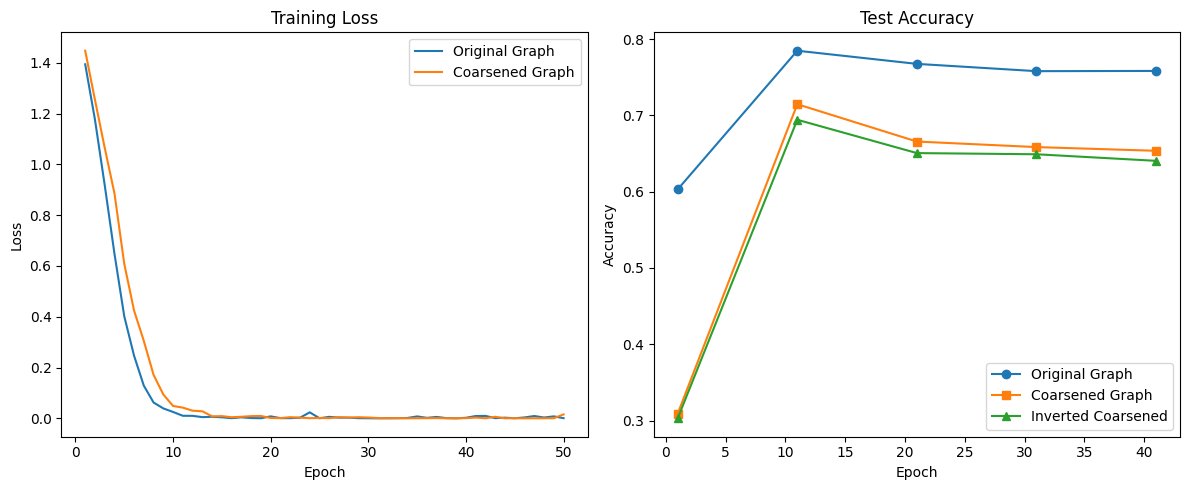

Final Performance Comparison:
Original Graph Accuracy: 0.7582
Coarsened Graph Accuracy: 0.6536
Inverted Coarsened Accuracy: 0.6404


In [10]:
# Import necessary libraries (if not already imported)
import torch
import torch.nn.functional as F
import numpy as np
from Models.GNNs.HGCN import ImprovedHeteroGNN


original_x_dict = o_x_dict
coarsened_x_dict = c_x_dict
o_metadata = (o_node_types, o_edge_types)
c_metadata=(c_node_types, c_edge_types)
#original_x_dict.update({"conference": torch.zeros((original_data["conference"]["num_nodes"], 1))})# = 0  #= 0#
#coarsened_x_dict.update({"conference": torch.zeros((coarsened_data["conference"]["num_nodes"], 1))})# = 0  #= 0#

#num_classes = len(original_data["author"]["label"].unique())

target_node_type = "author"
# Your existing model definition
model_original = ImprovedHeteroGNN(metadata=o_metadata,target_feat=target_node_type, x_dict= original_x_dict ,num_classes= 4,hidden_channels=64)
model_coarsened = ImprovedHeteroGNN(metadata=c_metadata, target_feat=target_node_type,x_dict= coarsened_x_dict,num_classes= 4, hidden_channels=64)

# Optimizers
optimizer_original = torch.optim.Adam(model_original.parameters(), lr=0.01, weight_decay=5e-4)
optimizer_coarsened = torch.optim.Adam(model_coarsened.parameters(), lr=0.01, weight_decay=5e-4)


# Function to apply inversion mapping from coarsened to original
def apply_inversion_mapping(coarsened_pred, inversion_map, original_labels, test_mask):
    """
    Maps predictions from coarsened graph back to original graph nodes
    
    Args:
        coarsened_pred: Predictions on coarsened graph
        inversion_map: Mapping from coarsened nodes to original nodes
        original_labels: Ground truth labels of original graph
        
    Returns:
        mapped_accuracy: Accuracy after applying inversion mapping
    """
    correct_count = 0
    total_count = 0
    
    for orig_node, coarsened_node in enumerate(inversion_map):
        if not test_mask[coarsened_node]:
            continue
        coarse_pred = coarsened_pred[coarsened_node].item()
        orig_label = original_labels[orig_node].item()
        #print(coarse_pred, orig_label)

        correct = (coarse_pred == orig_label)
                
        if correct:
            correct_count += 1
        total_count += 1
    
    return correct_count / total_count if total_count > 0 else 0

# Training function for original graph
def train_original():
    model_original.train()
    optimizer_original.zero_grad()
    
    out = model_original(original_x_dict, original_data.edge_index_dict)
    loss = F.nll_loss(
        out[target_node_type][original_data[target_node_type].train_mask], 
        original_data[target_node_type]["label"][original_data[target_node_type].train_mask]
    )
    loss.backward()
    optimizer_original.step()
    return loss.item()

# Training function for coarsened graph
def train_coarsened():
    model_coarsened.train()
    optimizer_coarsened.zero_grad()
    out = model_coarsened(coarsened_x_dict, coarsened_data.edge_index_dict)
    loss = F.nll_loss(
        out[target_node_type][coarsened_data[target_node_type].train_mask], 
        coarsened_data[target_node_type]["label"][coarsened_data[target_node_type].train_mask]
    )
    loss.backward()
    optimizer_coarsened.step()
    return loss.item()

# Evaluation function for original graph
def test_original():
    model_original.eval()
    with torch.no_grad():
        out = model_original(original_x_dict, original_data.edge_index_dict)
        pred = out[target_node_type].argmax(dim=1)
        
        # Calculate accuracy on test set
        correct = pred[original_data[target_node_type].test_mask] == original_data[target_node_type]["label"][original_data[target_node_type].test_mask]
        acc = int(correct.sum()) / int(original_data[target_node_type].test_mask.sum())
        return acc

# Evaluation function for coarsened graph
def test_coarsened():
    model_coarsened.eval()
    with torch.no_grad():
        out = model_coarsened(coarsened_x_dict, coarsened_data.edge_index_dict)
        pred = out[target_node_type].argmax(dim=1)
        
        # Calculate accuracy on test set
        coarsened_acc = int(
            (pred[coarsened_data[target_node_type].test_mask] == 
             coarsened_data[target_node_type]["label"][coarsened_data[target_node_type].test_mask]).sum()
        ) / int(coarsened_data[target_node_type].test_mask.sum())
        
        # Apply inversion mapping to evaluate how coarsened predictions map to original graph
        inverted_acc  = apply_inversion_mapping(
            pred,
            mapping_authors,
            original_data[target_node_type]["label"], 
            coarsened_data[target_node_type].test_mask
        )
       
        return coarsened_acc, inverted_acc

# Training for 50 epochs and comparing both models
results = {
    "epoch": [],
    "original_loss": [],
    "coarsened_loss": [],
    "original_acc": [],
    "coarsened_acc": [],
    "inverted_acc": []
}

for epoch in range(50):
    # Train both models
    original_loss = train_original()
    coarsened_loss = train_coarsened()
    
    # Store results
    results["epoch"].append(epoch+1)
    results["original_loss"].append(original_loss)
    results["coarsened_loss"].append(coarsened_loss)
    
    # Evaluate every 10 epochs
    if epoch % 10 == 0:
        original_acc = test_original()
        coarsened_acc, inverted_acc = test_coarsened()
        
        results["original_acc"].append(original_acc)
        results["coarsened_acc"].append(coarsened_acc)
        results["inverted_acc"].append(inverted_acc)
        
        print(f'Epoch {epoch+1}:')
    
    
        print(f'  Original Graph - Loss: {original_loss:.4f}, Accuracy: {original_acc:.4f}')
        print(f'  Coarsened Graph - Loss: {coarsened_loss:.4f}, Accuracy: {coarsened_acc:.4f}')
        print(f'  Inverted Coarsened - Accuracy: {inverted_acc:.4f}')
        print()

# Visualization of results
import matplotlib.pyplot as plt

# Plot loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(results["epoch"], results["original_loss"], label="Original Graph")
plt.plot(results["epoch"], results["coarsened_loss"], label="Coarsened Graph")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
x = [results["epoch"][i] for i in range(0, 50, 10)]
plt.plot(x, results["original_acc"], 'o-', label="Original Graph")
plt.plot(x, results["coarsened_acc"], 's-', label="Coarsened Graph")
plt.plot(x, results["inverted_acc"], '^-', label="Inverted Coarsened")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Test Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

# Final comparison
print("Final Performance Comparison:")
print(f"Original Graph Accuracy: {results['original_acc'][-1]:.4f}")
print(f"Coarsened Graph Accuracy: {results['coarsened_acc'][-1]:.4f}")
print(f"Inverted Coarsened Accuracy: {results['inverted_acc'][-1]:.4f}")

# Calculate speedup from using coarsened graph
# (You would need to time the training for a proper comparison)